

**Official Senegalese Zindi Hackathon : UmojaHack Senegal** aka Challenge Expresso sur la prédiction d’attrition des clients (churn)

![...](https://drive.google.com/uc?export=view&id=1pj7SGuqinFBy0yXrHLx6Eqi5BIcXVZbX)

# Install & Import libraries

In [ ]:
!pip install --quiet scikit-learn==0.22.2 seaborn==0.10.1 pandas==1.0.5 numpy==1.18.5 catboost==0.23.2  

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
import os, sys, gc
import random
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [ ]:
from catboost import CatBoostClassifier

# Envs

In [ ]:
seed = 1999


In [ ]:
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
PATH = {
    'dataset' : os.path.join( '..', 'DATASET',  ) ,

    'train' : os.path.join( '..', 'DATASET', 'CSV', 'Train.csv' ) ,
    'test' : os.path.join( '..', 'DATASET', 'CSV', 'Test.csv' ) ,
    'subSamp' : os.path.join( '..', 'DATASET', 'CSV', 'SampleSubmission.csv' ) ,
    'varDesc' : os.path.join( '..', 'DATASET', 'CSV', 'VariableDefinition.csv' ) ,
    
    'submissions' : os.path.join( '..', 'SUBMISSIONS', ) ,
}

# Utils

In [ ]:
def metric(y, pred):
  return log_loss(y, pred, labels=[0, 1])

# Read data

In [ ]:
train = pd.read_csv(PATH['train'])
test = pd.read_csv(PATH['test'])

In [ ]:
sample = pd.read_csv(PATH['subSamp'])

In [ ]:
train.shape

(2154048, 19)

In [ ]:
train = train.drop_duplicates().reset_index(drop=True)

In [ ]:
train.shape

(2154048, 19)

In [ ]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [ ]:
test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,THIES,K > 24 month,5000.0,5.0,5000.0,1667.0,5.0,NaN,378.0,11.0,5.0,NaN,NaN,NO,42,On-net 1000F=10MilF;10d,5.0
1,000055d41c8a62052dd426592e8a4a3342bf565d,NaN,I 18-21 month,300.0,2.0,326.0,109.0,3.0,397.0,NaN,0.0,NaN,NaN,NaN,NO,41,"Data: 100 F=40MB,24H",1.0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,DAKAR,K > 24 month,3300.0,25.0,3400.0,1133.0,26.0,7150.0,0.0,2.0,5.0,NaN,NaN,NO,57,"Data: 100 F=40MB,24H",22.0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,9,NaN,NaN
4,0000bae5480628cf8fe51ad84bcb39772fc79224,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,10,NaN,NaN


# Modeling

Here is an explanation of the features, I created :
*   Cont_tenure : It represents the duration of a customer in the network ;
*   { REVENUE-MONTANT, REVENUE/MONTANT } : this set of features access how much of his income, a customer is willing to spend ;

*   { TENURE/FREQUENCE_RECH, TENURE/REGULARITY } : this set of features access the customer loyalty ;

*   The  “ *_ mean_on_reg ”  features  are a wild estimation on how customers behave across different regions .

## Interactions

In [ ]:
tenure_mapper = {
  "K > 24 month": 24, 
  "I 18-21 month": 18, 
  "G 12-15 month": 12, 
  "H 15-18 month": 15, 
  "J 21-24 month": 21, 
  "F 9-12 month": 9, 
  "D 3-6 month": 3, 
  "E 6-9 month": 6,
}

train['cont_tenure'] = train['TENURE'].map(tenure_mapper)
test['cont_tenure'] = test['TENURE'].map(tenure_mapper)

In [ ]:
train['REVENUE-MONTANT'] = train['REVENUE'] - train['MONTANT']
train['REVENUE/MONTANT'] = train['REVENUE'] / train['MONTANT']
train['TENURE/FREQUENCE_RECH'] = train['cont_tenure'] / train['FREQUENCE_RECH']
train['TENURE/REGULARITY'] = train['cont_tenure'] / train['REGULARITY']

In [ ]:
test['REVENUE-MONTANT'] = test['REVENUE'] - test['MONTANT']
test['REVENUE/MONTANT'] = test['REVENUE'] / test['MONTANT']
test['TENURE/FREQUENCE_RECH'] = test['cont_tenure'] / test['FREQUENCE_RECH']
test['TENURE/REGULARITY'] = test['cont_tenure'] / test['REGULARITY']

## Groupby

In [ ]:
train.head(1)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,cont_tenure,REVENUE-MONTANT,REVENUE/MONTANT,TENURE/FREQUENCE_RECH,TENURE/REGULARITY
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0,24,1.0,1.000235,1.6,0.444444


In [ ]:
region = train.groupby('REGION').mean()

In [ ]:
reg_cols = region.columns.tolist()
reg_mapper = {}

for c in reg_cols:
  reg_mapper[c] = c+'_mean_on_reg'

In [ ]:
region.rename(columns=reg_mapper, inplace=True)
region['REGION'] = region.index
region.reset_index(drop=True, inplace=True)

## Merging

In [ ]:
region.REGION.nunique(), test.REGION.nunique(), train.REGION.nunique()

(14, 14, 14)

In [ ]:
train = train.merge(region, on='REGION', how='left')
test = test.merge(region, on='REGION', how='left')

In [ ]:
train.shape, test.shape

((2154048, 43), (380127, 42))

In [ ]:
target = 'CHURN'
columns = train.columns
conts = train.select_dtypes(include=np.number).columns.difference([target])
cats = train.select_dtypes(exclude=np.number).columns

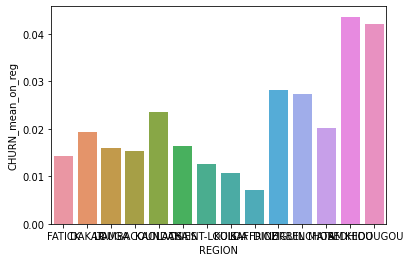

In [ ]:
sns.barplot(x='REGION', y='CHURN_mean_on_reg', data=train)

# Training

In [ ]:
n_skf = 5
kf = StratifiedKFold(n_skf)

params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': seed,
    'early_stopping_rounds': 100,
    'use_best_model': True,
}

In [ ]:
score = 0
test_oofs = []

for i, (tr_idx, vr_idx) in enumerate(kf.split(train, train[target])):
  X, Y = train.loc[tr_idx, conts], train.loc[tr_idx, target]
  x, y = train.loc[vr_idx, conts], train.loc[vr_idx, target]

  model = CatBoostClassifier(**params)
  model.fit(X, Y, eval_set=[(x,y)], verbose=10)
  p = model.predict_proba(x)[:, 1]
  pred = model.predict_proba(test[conts])[:, 1]
  sc = metric(y, p)

  score += sc/n_skf
  test_oofs.append(pred)

  print('Fold {} : {}'.format(i, sc))

print()
print()
print('Avg log : ', score)

0:	learn: 0.5574418	test: 0.5574314	best: 0.5574314 (0)	total: 818ms	remaining: 41m
10:	learn: 0.2717279	test: 0.2717671	best: 0.2717671 (10)	total: 9.27s	remaining: 42m 8s
20:	learn: 0.2562327	test: 0.2563130	best: 0.2563130 (20)	total: 17.7s	remaining: 41m 52s
30:	learn: 0.2537261	test: 0.2538436	best: 0.2538436 (30)	total: 26s	remaining: 41m 33s
40:	learn: 0.2529551	test: 0.2531133	best: 0.2531133 (40)	total: 34.3s	remaining: 41m 20s
50:	learn: 0.2525440	test: 0.2527459	best: 0.2527459 (50)	total: 42.8s	remaining: 41m 23s
60:	learn: 0.2522540	test: 0.2524918	best: 0.2524918 (60)	total: 51.2s	remaining: 41m 15s
70:	learn: 0.2520655	test: 0.2523438	best: 0.2523438 (70)	total: 59.6s	remaining: 41m 6s
80:	learn: 0.2519078	test: 0.2522149	best: 0.2522149 (80)	total: 1m 8s	remaining: 40m 59s
90:	learn: 0.2517770	test: 0.2521155	best: 0.2521155 (90)	total: 1m 16s	remaining: 40m 48s
100:	learn: 0.2516850	test: 0.2520499	best: 0.2520499 (100)	total: 1m 24s	remaining: 40m 42s
110:	learn: 0.25

# Prediction

In [ ]:
test_cols = ['user_id', target]

In [ ]:
test[target] = np.mean(test_oofs, axis=0)

# Distr

In [ ]:
test[test_cols].head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.000878
1,000055d41c8a62052dd426592e8a4a3342bf565d,0.080654
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0.000667
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0.395694
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0.377464


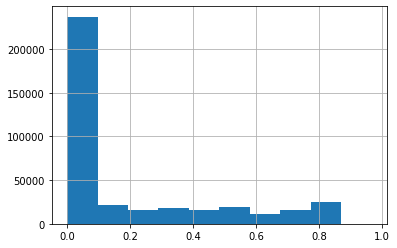

In [ ]:
test[target].hist()

# Submission

In [ ]:
def submit(sub, name):
    filepath = os.path.join(PATH['submissions'], name+'.csv')
    sub.to_csv( filepath, index=False)
    print(f"[INFO] Submission file created : {filepath} ")

In [ ]:
submit(test[['user_id', target]], f'vanilla_cat_no_fillna_seed={seed}_n-sfk={n_skf}_score={score}_')

[INFO] Submission file created : ../SUBMISSIONS/vanilla_cat_no_fillna_0.25102568495125444_2.csv 


In [ ]:
print("End")